In [50]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import random
from collections import defaultdict
from sklearn.dummy import DummyClassifier
import sklearn.model_selection as cv

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 12}
plt.rc('font', **font)

### Classifier

In [34]:
def get_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:,2:]
    return df

def class_split(df, lower_bound, upper_bound):
    df1 = df[(df['shares'] >= lower_bound) & (df['shares'] < upper_bound)]
    df2 = df[~((df['shares'] >= lower_bound) & (df['shares'] < upper_bound))]
    df2 = df2.sample(len(df1))
    return pd.concat([df1, df2])

def get_label(df, lower_bound, upper_bound):
    df['label'] = df['shares'].map(lambda x: 1 if (x >=lower_bound) & (x <upper_bound) else 0)
    return df

def get_feature_target(df, train_cols):
    X = df[train_cols]
    y = df['label']
    return X, y

def feature_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def model_eval(X_scaled, y, model):
    kf = KFold(n_splits=5, shuffle=True)
    score = []
    for train_idx, test_idx in kf.split(X_scaled):
        model.fit(X_scaled[train_idx], y.iloc[train_idx])
        y_pred = model.predict(X_scaled[test_idx])
        y_true = y.iloc[test_idx]
        score.append(f1_score(y_true, y_pred))
    return score

def model_output(train_cols, lower_bound, upper_bound):
    df = get_data('../data/train.csv')
    df = class_split(df, lower_bound, upper_bound)
    df = get_label(df, lower_bound, upper_bound)
    X, y = get_feature_target(df, train_cols)
    X_scaled = feature_scaling(X)
    return df, X_scaled, y
    
def get_model_score(train_cols, lower_bound, upper_bound):
    df, X_scaled, y = model_output(train_cols, lower_bound, upper_bound)
    base_model = DummyClassifier(strategy="stratified")
    rf = RandomForestClassifier(n_estimators=200, max_depth=59)
    lr = LogisticRegression(solver='sag')
    gb = GradientBoostingClassifier(n_estimators=200,
                                        max_depth=3, learning_rate=0.1, subsample=0.5,
                                        random_state=154)
    models = {'Baseline': base_model,
              'Random Forest': rf,
              'Logistics Regression': lr,
              'Gradient Boosting': gb
             }
    res = {}
    for k,v in models.items():
        score = model_eval(X_scaled, y, v)
        res[k] = np.average(score)
    return res

In [38]:
train_cols = ['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']

### Training Data

In [39]:
# not popular
not_popular = get_model_score(train_cols, 0, 944)
not_popular

{'Baseline': 0.49807501626212014,
 'Random Forest': 0.678830857984322,
 'Logistics Regression': 0.6638570610548518,
 'Gradient Boosting': 0.6835935625582779}

In [40]:
# mediocre
mediocre = get_model_score(train_cols, 945, 1400)
mediocre

{'Baseline': 0.4969702887191577,
 'Random Forest': 0.5576787831276236,
 'Logistics Regression': 0.56004555388926,
 'Gradient Boosting': 0.5671260877132708}

In [41]:
# popular
popular = get_model_score(train_cols, 1401, 2800)
popular

{'Baseline': 0.4996105894925017,
 'Random Forest': 0.5897748509766378,
 'Logistics Regression': 0.5754947201743696,
 'Gradient Boosting': 0.5869565692137775}

In [42]:
# super popular
super_popular = get_model_score(train_cols, 2801, 843300)
super_popular

{'Baseline': 0.49526081865669624,
 'Random Forest': 0.6573162678792943,
 'Logistics Regression': 0.6280910115466001,
 'Gradient Boosting': 0.6533742248590668}

In [43]:
not_popular['Baseline']

0.49807501626212014

Text(0.5, 1.0, 'Multi-Classes F1 Score')

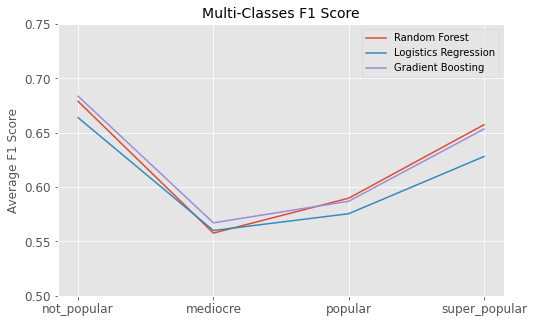

In [66]:
fig, ax = plt.subplots(figsize=(8,5))
lst = ['Random Forest', 'Logistics Regression', 'Gradient Boosting']
x = ['not_popular','mediocre','popular','super_popular']
for i in lst:
    y = [not_popular[i], mediocre[i], popular[i], super_popular[i]]
    ax.plot(x, y, label=i)
ax.legend(loc = "upper right", fontsize=10)
plt.ylim([0.5, 0.75])
ax.set_ylabel('Average F1 Score', fontsize=12)
ax.set_title("Multi-Classes F1 Score", fontsize=14)

### Test Data